<a href="https://colab.research.google.com/github/duarte3333/Machine_Learning/blob/main/task1_imageanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

def load_data():
    """ Load the training and test data. """
    #2352 elements each image: 2352 = pixels x pixels x 3 (RGB)
    X = np.load('Xtrain_Classification1.npy') #6254 x 2352. 2352 = pixels x pixels x 3 (RGB). Training set is inbalanced, different number of samples for each class
    y = np.load('ytrain_Classification1.npy') #6254. 1D vector
    X_t = np.load('Xtest_Classification1.npy') #1764 x 2352. Has data from two distinct sources
    return X, y, X_t

def preprocess_data(X, X_t):
    """ This function scale the training data to be in the range [0, 1]
    and the data type to float32 for numerical stability """
    Xs = (X).astype('float32') / np.max(X) #Scale down data [0,1]
    Xs_test = (X_t).astype('float32') / np.max(X)
    return Xs, Xs_test

def encode_data(y, Xs, Xs_test):
    """ Enconde data function """
    train_labels = keras.utils.to_categorical(y,num_classes=2) #One-hot enconding: 6254 x 2 matrix that is 0 or 1 depending on class
    train_images = np.reshape(Xs, (len(Xs[:,0]),28,28,3)) #4D array. number of images x width x height x color
    test_images = np.reshape(Xs_test, (len(Xs_test[:,0]), 28, 28, 3))
    return train_labels, train_images, test_images

def shuffle_data(train_images, train_labels):
    permutation = np.random.permutation(len(train_images))
    train_images_s = train_images[permutation]
    train_labels_s = train_labels[permutation]
    return train_images_s, train_labels_s

def split_data(train_images_s, train_labels_s):
    X_train, X_validation, y_train, y_validation = train_test_split(train_images_s, train_labels_s, test_size=0.2)
    print(X_train.shape)
    print(y_train.shape)
    return X_train, X_validation, y_train, y_validation

def plot_images(number_images,X_train):
  '''Plot a user defined number of images from X_train. Only really works for 10 images'''

  number_images = 10

  plt.figure(figsize=(12, 6))
  for i in range(number_images):
      plt.subplot(2, 5, i + 1)
      plt.imshow(X_train[i])
      plt.title(f"Image {i+1}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

In [18]:
X, y, X_t = load_data()
Xs, Xs_test = preprocess_data(X, X_t)
train_labels, train_images, test_images = encode_data(y, Xs, Xs_test)
train_images_s, train_labels_s = shuffle_data(train_images, train_labels)
X_train, X_validation, y_train, y_validation = split_data(train_images_s, train_labels_s)

In [ ]:
plot_images(10, X_train)

# First approach: MLP with imbalanced data

In [61]:
#Building MLP neural network, Sequential (linear stack of Layers)
#kernel size 3 by 3 is normal in image data
#padding keeps images in the same size
#poolsize and strides -> Check notes on notion on maxpooling
def MLP_NN():
    MLP = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding= 'same', input_shape = (28,28,3)),
        MaxPool2D(pool_size =(2,2), strides=2),
        Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        Flatten(), #Flatten is always needed before using fully connected layer (Dense) for output
        Dense(units=2, activation='softmax')
    ])
    #MLP.summary() #See created neural network
    return MLP

def MLP_NN():
    MLP = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', padding= 'same', input_shape = (28,28,3)),
        MaxPool2D(pool_size =(2,2), strides=2),
        Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        Flatten(), #Flatten is always needed before using fully connected layer (Dense) for output
        Dense(units=2, activation='softmax')
    ])
    #MLP.summary() #See created neural network
    return MLP

def Compile_MLP(MLP):
    MLP.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

def train_model(MLP):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    return MLP.fit(x=X_train, y=y_train, validation_data=(X_validation, y_validation), \
            batch_size=512, epochs=200, shuffle = True, verbose=2, callbacks=[early_stop])

def make_predictions(MLP):
    predictions = MLP.predict(x = test_images, batch_size = 200, verbose=0) #Returns probability of each class
    rounded_predictions= np.argmax(predictions, axis=-1) #Rounds it to 0 or 1
    return rounded_predictions
    
def plot_loss(history):
    #Plot loss evolution in each epoch for training and validation set
    plt.figure(1)
    plt.clf()
    plt.plot(history.history['loss'], label='train'),
    plt.plot(history.history['val_loss'], label='train'), plt.show()
    
MLP = MLP_NN()
Compile_MLP(MLP)

In [ ]:
history = train_model(MLP) # Train MLP model
# Note: Try 'SparseCategoricalCrossEntropy' as loss function.

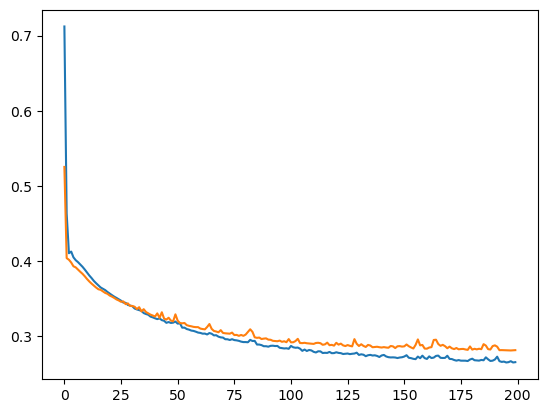

Train - Mean loss:  0.26549482345581055
Test - Mean Val loss:  0.2814697325229645
Accuracy:  0.8810713291168213


In [59]:
plot_loss(history)
print("Train - Mean loss: ", (history.history['loss'][-1]))
print("Test - Mean Val loss: ", np.mean(history.history['val_loss'][-1]))
print("Accuracy: ", np.mean(history.history['accuracy'][-1]))

**Right now we have a have an overfitted neural network.**




In [34]:
rounded_predictions = make_predictions(MLP) #Make predictions
#Visualize imbalance in training data
cont_0 = 0
for i in rounded_predictions:
  if i == 0:
    cont_0 += 1
print(cont_0, len(test_images[:,0])-cont_0) #Big difference between classes due to imbalanced training set

[0 0 0 ... 0 0 1]


# Second approach: MLP with balanced data

In [ ]:
#Create ways to do data augmentation
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                          height_shift_range=0.1, shear_range=0.15,
                         zoom_range=0.1, channel_shift_range=10,
                         horizontal_flip=True, vertical_flip = True)